In [ ]:
pip install opencv-python-headless

In [ ]:
pip install moviepy

In [4]:
# Import necessary packages
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import math

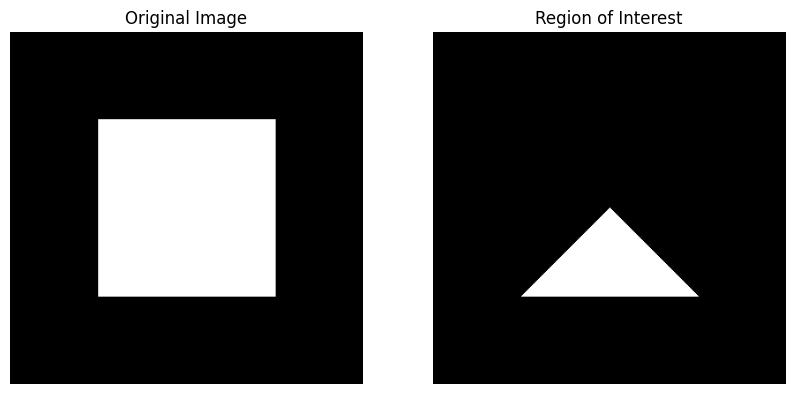

In [5]:
def interested_region(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2: 
        mask_color_ignore = (255,) * img.shape[2]
    else:
        mask_color_ignore = 255
        
    cv2.fillPoly(mask, vertices, mask_color_ignore)
    return cv2.bitwise_and(img, mask)

# Create a sample image (e.g., a blank black image with a white rectangle)
img = np.zeros((400, 400, 3), dtype=np.uint8)
cv2.rectangle(img, (100, 100), (300, 300), (255, 255, 255), -1)

# Define the vertices of the polygonal region of interest
vertices = np.array([[(100, 300), (200, 200), (300, 300), (200, 400)]], dtype=np.int32)

# Apply the interested_region function
roi_img = interested_region(img, vertices)

# Display the original image and the image with the region of interest
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Region of Interest")
plt.imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

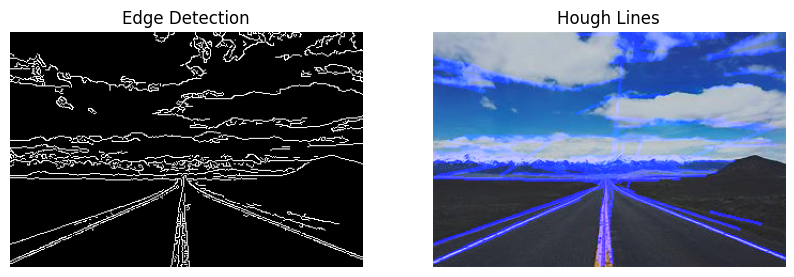

In [8]:

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines_drawn(line_img, lines)
    return line_img

def lines_drawn(img, lines):
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw blue lines with thickness of 2

# Example usage
if __name__ == "__main__":
    img_path = 'road.jpeg'  
    img = cv2.imread(img_path)
    
    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Unable to load image at {img_path}")
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply edge detection 
        edges = cv2.Canny(gray, 50, 150)

        # Define Hough Transform parameters
        rho = 1 
        theta = np.pi / 180  
        threshold = 15 
        min_line_len = 40 
        max_line_gap = 20 

        # Apply the hough_lines function
        line_img = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)

        # Overlay the lines on the original image
        combined_img = cv2.addWeighted(img, 0.8, line_img, 1, 0)

        # Display the result
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Edge Detection")
        plt.imshow(edges, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Hough Lines")
        plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()


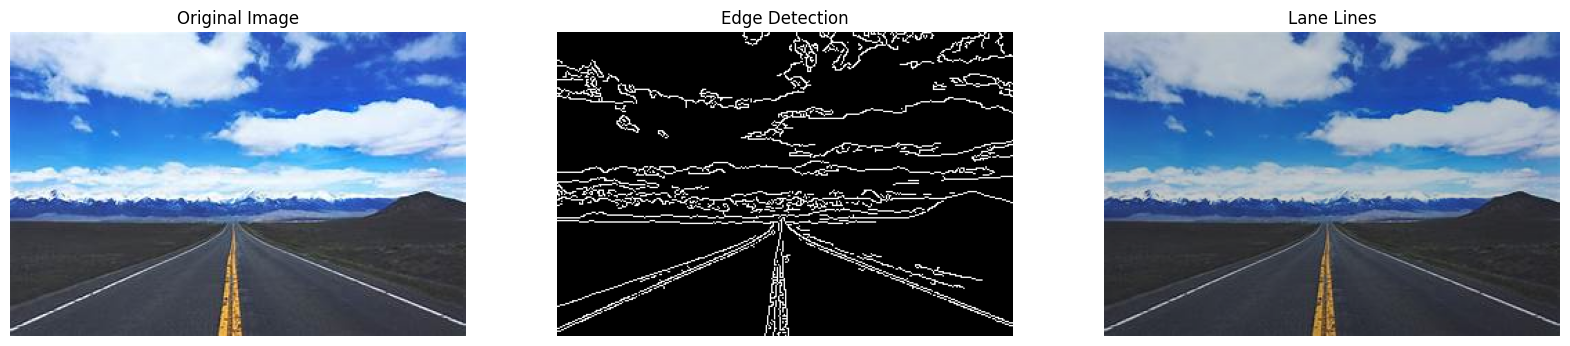

In [13]:

def lines_drawn(img, lines, color=[255, 0, 0], thickness=6):
    global cache
    global first_frame
    slope_l, slope_r = [], []
    lane_l, lane_r = [], []

    α = 0.2 
    min_y = img.shape[0]  # Initialize the minimum y-coordinate to the height of the image

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if slope > 0.4:
                slope_r.append(slope)
                lane_r.append(line)
            elif slope < -0.4:
                slope_l.append(slope)
                lane_l.append(line)
            min_y = min(y1, y2, min_y)  # Update the minimum y-coordinate

    if (len(lane_l) == 0) or (len(lane_r) == 0):
        print('no lane detected')
        return 1

    slope_mean_l = np.mean(slope_l, axis=0)
    slope_mean_r = np.mean(slope_r, axis=0)
    mean_l = np.mean(np.array(lane_l), axis=0)
    mean_r = np.mean(np.array(lane_r), axis=0)

    if (slope_mean_r == 0) or (slope_mean_l == 0):
        print('dividing by zero')
        return 1

    x1_l = int((min_y - mean_l[0][1] - (slope_mean_l * mean_l[0][0])) / slope_mean_l) 
    x2_l = int((min_y - mean_l[0][1] - (slope_mean_l * mean_l[0][0])) / slope_mean_l)   
    x1_r = int((min_y - mean_r[0][1] - (slope_mean_r * mean_r[0][0])) / slope_mean_r)
    x2_r = int((min_y - mean_r[0][1] - (slope_mean_r * mean_r[0][0])) / slope_mean_r)

    if x1_l > x1_r:
        x1_l = int((x1_l + x1_r) / 2)
        x1_r = x1_l
        y1_l = int((slope_mean_l * x1_l) + mean_l[0][1] - (slope_mean_l * mean_l[0][0]))
        y1_r = int((slope_mean_r * x1_r) + mean_r[0][1] - (slope_mean_r * mean_r[0][0]))
        y2_l = int((slope_mean_l * x2_l) + mean_l[0][1] - (slope_mean_l * mean_l[0][0]))
        y2_r = int((slope_mean_r * x2_r) + mean_r[0][1] - (slope_mean_r * mean_r[0][0]))
    else:
        y1_l = img.shape[0]
        y2_l = img.shape[0]
        y1_r = img.shape[0]
        y2_r = img.shape[0]

    present_frame = np.array([x1_l, y1_l, x2_l, y2_l, x1_r, y1_r, x2_r, y2_r], dtype="float32")

    if first_frame == 1:
        next_frame = present_frame        
        first_frame = 0        
    else:
        prev_frame = cache
        next_frame = (1 - α) * prev_frame + α * present_frame

    cv2.line(img, (int(next_frame[0]), int(next_frame[1])), (int(next_frame[2]), int(next_frame[3])), color, thickness)
    cv2.line(img, (int(next_frame[4]), int(next_frame[5])), (int(next_frame[6]), int(next_frame[7])), color, thickness)

    cache = next_frame

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines_drawn(line_img, lines)
    return line_img

# Main script
if __name__ == "__main__":
    # Read a sample image
    img_path = 'road.jpeg'  # Update this path to the correct location of your image
    img = cv2.imread(img_path)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Unable to load image at {img_path}")
    else:
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply edge detection (e.g., Canny)
        edges = cv2.Canny(gray, 50, 150)

        # Define Hough Transform parameters
        rho = 1  # 1 pixel
        theta = np.pi / 180  # 1 degree
        threshold = 15  # Minimum number of votes
        min_line_len = 40  # Minimum length of line in pixels
        max_line_gap = 20  # Maximum gap between lines

        # Apply the hough_lines function
        line_img = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)

        # Overlay the lines on the original image
        combined_img = cv2.addWeighted(img, 0.8, line_img, 1, 0)

        # Display the result
        plt.figure(figsize=(20, 10))

        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Edge Detection")
        plt.imshow(edges, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Lane Lines")
        plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()
